# 信息增益与上下文相关性

In [1]:
from datetime import datetime
# 打印当前时间，按照年-月-日 小时:分钟:秒的格式
print("Start time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 记录开始时间
from time import time
start = time()

Start time: 2024-12-15 10:27:46


In [2]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

## 1. 数据过滤条件
- len(responses) > 8 and len(cluster_ids) == len(responses)
- 'entropy' in data
- 'accuracy' in data
- greedy_*，3个上下文设定必须都符合上述条件

**先看看qwen + squad/triviaqa有多少满足条件的数据**

In [ ]:
# def filter_example(example):
#     if example

In [ ]:
# Create Dataset class for easier attribute keeping
class Dataset:
    name = ''
    tbg_dataset = None
    slt_dataset = None
    entropy = None
    accuracies = None

    sample_type = ''
    model_name = ''
    dataset_name = ''
    split = ''
    def __init__(self, name, tbg_dataset, slt_dataset, entropy, accuracies, sample_type, model_name, dataset_name, split):
        self.name = name
        self.tbg_dataset = tbg_dataset
        self.slt_dataset = slt_dataset
        self.entropy = entropy
        self.accuracies = accuracies
        self.sample_type = sample_type
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.split = split

%time all_data = load_pickle_file("output/data/all_data.pkl")

In [ ]:
# entropy是连续值(-inf，+inf)，accuracy是离散值{-1, 0, 1}
def plot_boxplot(entropy, accuracy, dataset):
    import torch
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    # 转换为 Pandas DataFrame
    data = pd.DataFrame({'entropy': entropy.numpy(), 'accuracy': accuracy.numpy()})

    # 绘制箱线图
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='accuracy', y='entropy', data=data)
    plt.title(f"{dataset}")
    plt.xlabel("Diff Accuracy")
    plt.ylabel("Diff Entropy")
    plt.grid(axis='y')
    plt.show()

In [48]:
'''
提琴图
- entropy是连续值(-inf，+inf)，accuracy是离散值{-1, 0, 1}
- inner="box" 会在提琴图内嵌入箱型图，展示数据的基本统计特征。
- 如果希望仅展示密度信息，可以将 inner="box" 替换为 inner=None。
'''
def plot_violinplot(entropy, accuracy, title):
    import torch
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # 转换为 Pandas DataFrame
    data = pd.DataFrame({'entropy': entropy.numpy(), 'accuracy': accuracy.numpy()})

    # 绘制提琴图
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='accuracy', y='entropy', data=data, inner="box")  # inner="box" 显示箱线信息
    # sns.violinplot(x='accuracy', y='entropy', data=data, inner=None)
    plt.title(title)
    plt.xlabel("Diff Accuracy")
    plt.ylabel("Diff Entropy")
    plt.grid(axis='y')
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_calibration_curve(diff_entropy, diff_accuracy, num_bins=10):
    """
    绘制校准曲线，观测 diff_entropy 和 diff_accuracy 的关系

    参数:
    - diff_entropy (torch.Tensor): 表示熵差异的张量，形状为 [N]
    - diff_accuracy (torch.Tensor): 表示准确率差异的张量，形状为 [N]
    - num_bins (int): 分桶的数量，默认值为 10

    返回:
    - None
    """
    # 分桶
    bin_edges = torch.linspace(diff_entropy.min(), diff_entropy.max(), num_bins + 1)
    bin_indices = torch.bucketize(diff_entropy, bin_edges)

    # 计算每个桶中 diff_entropy 和 diff_accuracy 的平均值
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean_diff_accuracy = [
        diff_accuracy[bin_indices == i].mean().item() if (bin_indices == i).sum() > 0 else None
        for i in range(1, num_bins + 1)
    ]

    # 绘制校准曲线
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, mean_diff_accuracy, marker='o', label="Calibration Curve")
    plt.title("Calibration Curve: diff_entropy vs diff_accuracy")
    plt.xlabel("Mean diff_entropy (binned)")
    plt.ylabel("Mean diff_accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

# 示例调用
diff_entropy = torch.randn(2000)  # 假设是熵的差异值
diff_accuracy = torch.randn(2000)  # 假设是准确率的差异值
plot_calibration_curve(diff_entropy, diff_accuracy, num_bins=10)

In [ ]:
# 对一个tensor进行归一化处理，从-1到1，并取相反数
def normalize_tensor(tensor):
    return 1 - (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 2

diff acc: 0.6165000200271606, 0.5191941261291504
diff entropy: -0.6818509697914124, 0.7279437184333801


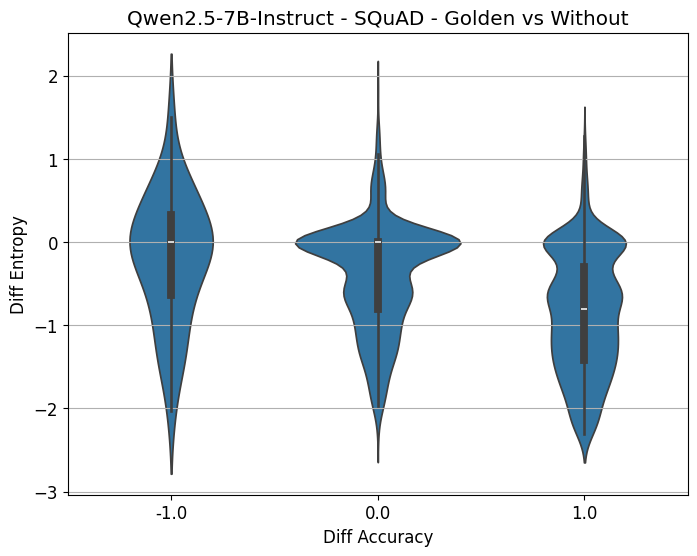

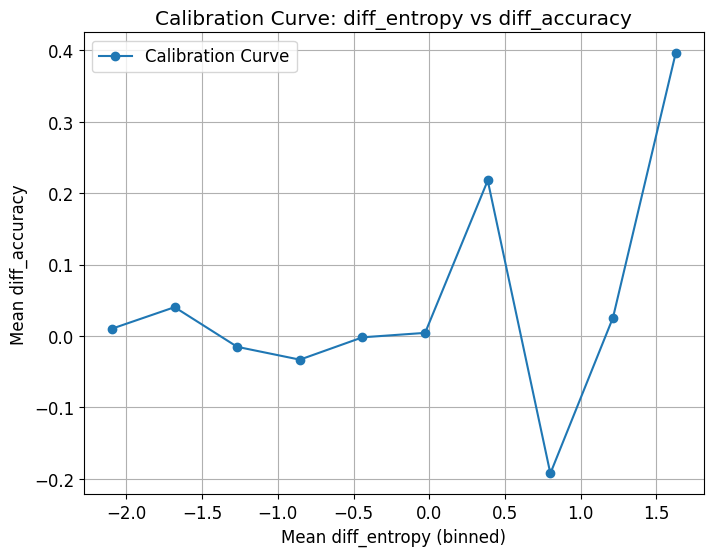

In [72]:
golden_acc = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['golden'].accuracies
without_acc = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['without'].accuracies
diff_acc = golden_acc - without_acc
print(f"diff acc: {diff_acc.mean()}, {diff_acc.std()}")

golden_entropy = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['golden'].entropy
without_entropy = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['without'].entropy
diff_entropy = golden_entropy - without_entropy
# diff_entropy = normalize_tensor(diff_entropy)
print(f"diff entropy: {diff_entropy.mean()}, {diff_entropy.std()}")

# 查看diff_acc和diff_entropy的相关性
plot_violinplot(diff_entropy, diff_acc, "Qwen2.5-7B-Instruct - SQuAD - Golden vs Without")
plot_calibration_curve(diff_entropy, diff_accuracy, num_bins=10)

diff acc: 0.765500009059906, 0.4377277195453644
diff entropy: -0.9100800156593323, 0.6420660614967346


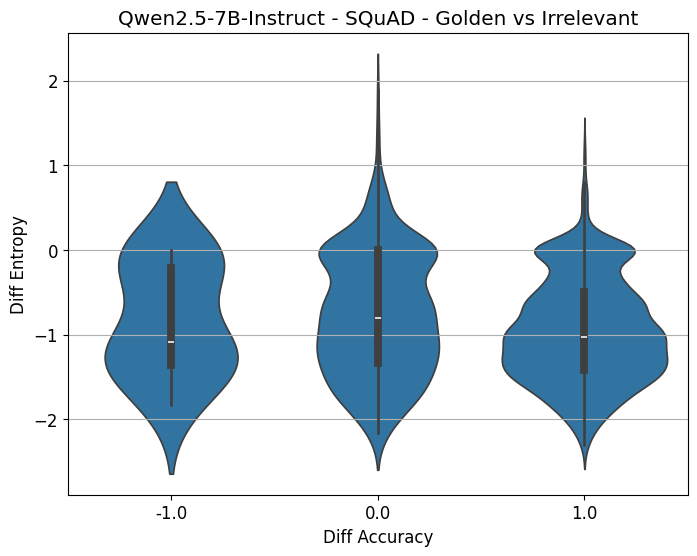

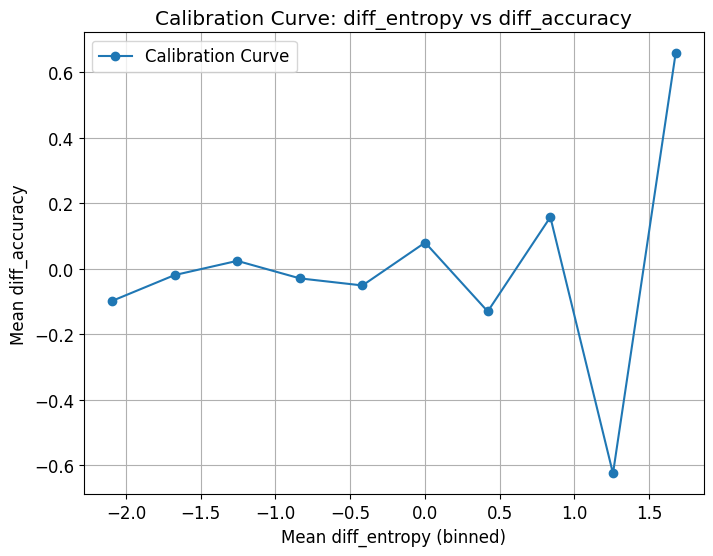

In [73]:
golden_acc = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['golden'].accuracies
irrelevant_acc = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['irrelevant'].accuracies
diff_acc = golden_acc - irrelevant_acc
print(f"diff acc: {diff_acc.mean()}, {diff_acc.std()}")

golden_entropy = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['golden'].entropy
irrelevant_entropy = all_data['Qwen/Qwen2.5-7B-Instruct']['squad']['train']['irrelevant'].entropy
diff_entropy = golden_entropy - irrelevant_entropy
# diff_entropy = normalize_tensor(diff_entropy)
print(f"diff entropy: {diff_entropy.mean()}, {diff_entropy.std()}")

# 查看diff_acc和diff_entropy的相关性
plot_violinplot(diff_entropy, diff_acc, "Qwen2.5-7B-Instruct - SQuAD - Golden vs Irrelevant")
plot_calibration_curve(diff_entropy, diff_accuracy, num_bins=10)